In [1]:
# Add path
import os
import sys
# project_root = os.path.dirname(os.path.abspath('..'))
project_root = os.path.dirname(os.path.dirname(os.path.abspath('..')))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

# Reload modules
from importlib import reload

In [2]:
import torch
from src.utils.dataset_dev import load_wandb_model, dataloader_from_wandb_cfg, data_from_loader

# Load model and dataset
run_id = 'e51hcsb9'
model, cfg = load_wandb_model(run=run_id, name='epoch=57.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../train/config.yaml',
                              wandb_cache_path='/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/wandb_cache')
# /cephfs/store/gr-mc2473/lc865/wandb_cache

/Users/luis/opt/anaconda3/envs/simexpr-arm64/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/Users/luis/opt/anaconda3/envs/simexpr-arm64/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


dict_keys(['encoder.mlp.net.0.weight', 'encoder.mlp.net.0.bias', 'encoder.mlp.net.2.weight', 'encoder.mlp.net.2.bias', 'encoder.mlp.net.2.running_mean', 'encoder.mlp.net.2.running_var', 'encoder.mlp.net.2.num_batches_tracked', 'encoder.mlp.net.3.block.0.weight', 'encoder.mlp.net.3.block.0.bias', 'encoder.mlp.net.3.block.2.weight', 'encoder.mlp.net.3.block.2.bias', 'encoder.mlp.net.3.block.2.running_mean', 'encoder.mlp.net.3.block.2.running_var', 'encoder.mlp.net.3.block.2.num_batches_tracked', 'encoder.mlp.net.3.block.3.weight', 'encoder.mlp.net.3.block.3.bias', 'encoder.mlp.net.3.block.5.weight', 'encoder.mlp.net.3.block.5.bias', 'encoder.mlp.net.3.block.5.running_mean', 'encoder.mlp.net.3.block.5.running_var', 'encoder.mlp.net.3.block.5.num_batches_tracked', 'encoder.mlp.net.4.block.0.weight', 'encoder.mlp.net.4.block.0.bias', 'encoder.mlp.net.4.block.2.weight', 'encoder.mlp.net.4.block.2.bias', 'encoder.mlp.net.4.block.2.running_mean', 'encoder.mlp.net.4.block.2.running_var', 'encod

/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/utils/dataset_dev.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

In [9]:
batch_size = 1
syntax_shape = (batch_size, cfg.model.io_format.seq_len, cfg.model.io_format.token_cnt)
x = torch.zeros(syntax_shape, dtype=torch.float32)
sample_eps = 1e-3
sample_count = 8
input = {
    'input_sample': x,
    'sample_eps': sample_eps,
    'sample_count': sample_count
}

In [7]:
fpath = f'./onnx-models/model-{run_id}.onnx'
print(os.path.abspath(fpath))


/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/ONNX_conversion/onnx-models/model-e51hcsb9.onnx


In [11]:
fpath = f'./onnx-models/model-{run_id}.onnx'
model.to_onnx(fpath, tuple(input.values()), export_params=True)

## 2. Load model via ONNX

In [10]:
train_loader, valid_loader, info = dataloader_from_wandb_cfg(
    cfg, 
    datapath='/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/data',
    max_length=1000, 
    allow_different_dataset_hash=True
)
input_arr = data_from_loader(train_loader, 'x', idx=0).detach().numpy()

Using dataset "dataset_250110_2" of size 900
DataLoader Summary
---------------------------------------------------------------------
  | Train        | Size: 900     | Batch: 512   | Batches: 1    
  | valid        | Size: 100     | Batch: 512   | Batches: 0    
---------------------------------------------------------------------


In [25]:
import onnxruntime
import numpy as np

sample_eps, sample_count = 1e-1, 8

ort_session = onnxruntime.InferenceSession(fpath)
ort_inputs = {
    ort_session.get_inputs()[0].name: input_arr, 
    ort_session.get_inputs()[1].name: np.array([sample_eps], dtype=np.float64),
    ort_session.get_inputs()[2].name: np.array([sample_count], dtype=np.int64)
}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(8, 15, 12)

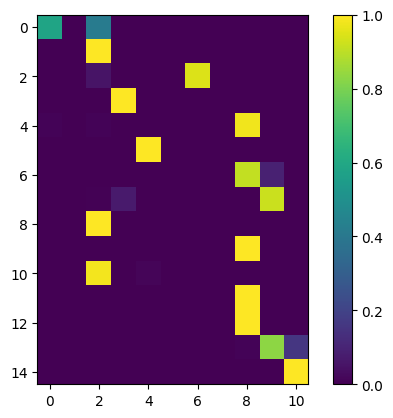

In [33]:
from matplotlib import pyplot as plt

i = 2
plt.imshow(torch.tensor(ort_outs[0][i].squeeze()[:, :-1]).softmax(dim=-1).detach().numpy())
plt.colorbar()
plt.show()